In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, utils, backend, callbacks

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import uproot


2023-12-18 13:39:43.474377: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-18 13:39:44.253396: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 13:39:46.750670: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#@keras.saving.register_keras_serializable(package="CustomModel", name="DNN2")
class DNN(keras.Model):
    def __init__(self, sizes=(100, 100, 100), outputDims=2, inputDims=None, **kwargs):
        super().__init__(**kwargs)
        self._outputShape=outputDims
        self._denseSizes=sizes
        self._inputShape=inputShape

        self._inputs = keras.Input(shape=inputDims)
        self._layers = []
        for i, size in enumerate(sizes):
            _layer = layers.Dense(size, kernel_initializer="he_uniform", kernel_regularizer=keras.regularizers.L1L2(l2=1e-4))
            _activation = layers.Activation("relu")
            self._layers.extend([_layer, _activation])

        _layer = layers.Dense(outputDims)
        _activation = layers.Activation("softmax")
        self._layers.extend([_layer, _activation])

        self._outputs = self.call(self._inputs)
        self._model = keras.Model(self._inputs, self._outputs)

    def call(self, inputs):
        self._tensors = [inputs]
        for _layer in self._layers:
            tensor = _layer(self._tensors[-1])
            self._tensors.append(tensor)
        return self._tensors[-1]

    def get_config(self):
        config = super().get_config()
        config.update({
            "sizes": self._denseSizes,
            "outputDims": self._outputShape,
            "inputDims": self._inputShape,
        })
        return config

    def model(self):
        return self._model

In [5]:
# drive.mount("/content/gdrive", force_remount=True)

# matches = uproot.open("/content/gdrive/My Drive/dataFiles/embeddingNtuples_20231023_4256.root:matches")
#matches.show()

trees = [uproot.open("/home/prozorov/dev/star/output_jets.root:Jets")]

sim_mc_reco= trees[0].arrays(["McJetPt", "McJetD0Z", 
                            #   "McJetLambda_1_1", "McJetLambda_1_1half","McJetLambda_1_2","McJetLambda_1_3",
                              "RecoJetPt","RecoJetD0Z",
                            #   "RecoJetLambda_1_1", "RecoJetLambda_1_1half","RecoJetLambda_1_2","RecoJetLambda_1_3"
                            ],  
                              "(Centrality < 2) & (RecoJetD0Z > -30) & (RecoJetD0Z < 30) & (RecoJetNConst!=0)", library="pd", entry_stop=1000000)


columns = ['pt', 'z']


mc = sim_mc_reco.iloc[:,0:2]
reco = sim_mc_reco.iloc[:,2:4]


mc.rename(columns={"McJetPt": "pt", "McJetD0Z": "z", }, inplace=True)
reco.rename(columns={"RecoJetPt": "pt", "RecoJetD0Z": "z"}, inplace=True)


print(reco.head())
print(mc.head())

trainGen, testGen, trainReco, testReco = train_test_split(mc, reco, test_size=0.2)

print("train-test split Gen: ", trainGen.shape, testGen.shape)
print(trainGen.head())
print(testGen.head())

print("train-test split Reco: ", trainReco.shape, testReco.shape)
print(trainReco.head())
print(testReco.head())



           pt         z
35  10.704795  0.220885
43  14.889277  0.223511
46  -1.206370 -3.925730
56   3.941502  0.711441
57   4.378250  1.018255
          pt         z
35  2.983089  0.852240
43  3.299773  1.000000
46  5.479533  0.856642
56  3.311914  0.866401
57  4.709603  0.929342
train-test split Gen:  (63962, 2) (15991, 2)
              pt         z
217111  3.128336  1.000000
454956  4.692349  0.588334
269545  4.655381  0.647591
531776  3.454292  1.000000
440369  2.142554  1.000000
              pt         z
281996  6.049345  0.441467
287297  1.888690  0.734051
946418  5.589930  0.397033
650303  4.355788  0.687382
858216  3.823852  0.565590
train-test split Reco:  (63962, 2) (15991, 2)
               pt          z
217111   7.952371   0.397193
454956  13.380087   0.209352
269545  -1.384463  -2.205596
531776  -0.313540 -10.851152
440369   0.249991   8.802291
               pt          z
281996   5.839378   0.438699
287297  12.911404   0.106682
946418   5.965845   0.370600
650303   0.23

In [6]:
nData, nEmbedding = np.count_nonzero(Y_det[:,1]), np.count_nonzero(Y_det[:,0])
#wtest[key] = np.ones(ntest[key])
wData = testWts.to_numpy()
#wtrain[key] = ntest[key]/ntrain[key]*np.ones(ntrain[key])
wEmbedding = (testWts.sum()/trainWts.sum()*trainWts).to_numpy()

print(np.sum(wEmbedding), np.sum(wData))
print(np.sum(testWts), np.sum(trainWts))

#now = datetime.now()
#nownow = now.strftime("%d-%m-%Y_%H-%M-%S")
folderPath = "/content/gdrive/MyDrive/savedModels/savedModel_"

lossFunc="binary_crossentropy"
optimizer="adam"
metricList=["accuracy"]

patience=10

validationSize = 0.2
nEpochs = 50
batchSize = 1000

inputShape = X_det.shape[1:]

w_sim = [wEmbedding]
nIter = 4
for i in range(nIter):
  detModel = DNN(sizes=(100, 100, 100), outputDims=2, inputDims=inputShape)
  detModel.compile(loss=lossFunc, optimizer=optimizer, metrics=metricList, weighted_metrics=[])
  detModel.model().summary()
  detCallBacks = [callbacks.EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)]
  detModelFilePath = folderPath + f"step1_iteration{i}"+"_epoch{epoch}"
  detCallBacks.append(callbacks.ModelCheckpoint(detModelFilePath, save_best_only=True, verbose=1))

  genModel = DNN(sizes=(100, 100, 100), outputDims=2, inputDims=inputShape)
  genModel.compile(loss=lossFunc, optimizer=optimizer, metrics=metricList, weighted_metrics=[])
  genModel.model().summary()
  genCallBacks = [callbacks.EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)]
  genModelFilePath = folderPath + f"step2_iteration{i}"+"_epoch{epoch}"
  genCallBacks.append(callbacks.ModelCheckpoint(genModelFilePath, save_best_only=True, verbose=1))

  if(i > 0):
    detModel.load_weights(folderPath + f"step1_iteration{i-1}")
    genModel.load_weights(folderPath + f"step2_iteration{i-1}")

  w_det = np.concatenate([wData, w_sim[-1]])

  X_det_train, X_det_val, Y_det_train, Y_det_val, w_det_train, w_det_val = train_test_split(X_det, Y_det, w_det, test_size=validationSize)
  detModel.fit(X_det_train, Y_det_train, sample_weight=w_det_train, epochs=nEpochs, batch_size=batchSize, validation_data=(X_det_val, Y_det_val, w_det_val), verbose=1, callbacks=detCallBacks)
  detModel.save_weights(folderPath + f"step1_iteration{i}")
  prediction = detModel.predict(X_det, batch_size=batchSize*10)
  scaleFactors = prediction[Y_det[:, 0] == 1]

  _pull = (scaleFactors[:, 1]/(scaleFactors[:, 0] + backend.epsilon()))*w_sim[-1]
  w_sim.append(_pull)

  w_gen = np.concatenate([w_sim[-1], w_sim[0]])

  X_gen_train, X_gen_val, Y_gen_train, Y_gen_val, w_gen_train, w_gen_val = train_test_split(X_gen, Y_gen, w_gen, test_size=validationSize)
  genModel.fit(X_gen_train, Y_gen_train, sample_weight=w_gen_train, epochs=nEpochs, batch_size=batchSize, validation_data=(X_gen_val, Y_gen_val, w_gen_val), verbose=1, callbacks=genCallBacks)
  genModel.save_weights(folderPath + f"step2_iteration{i}")
  prediction = genModel.predict(X_gen, batch_size=batchSize*10)
  scaleFactors = prediction[Y_gen[:, 0] == 1]

  _push = (scaleFactors[:, 1]/(scaleFactors[:, 0] + backend.epsilon()))*w_sim[-1]
  w_sim.append(_push)


NameError: name 'Y_det' is not defined

In [8]:
#columns = ["_wt", "_pt", "_eta", "_phi", "_nCharged", "_girth", "_ptd", "_lesub"]
feature = "pt"
Min = 0.
Max = 13.
nBins = 12

cpt1, binpt1 = np.histogram(trainGen[feature], bins=nBins, range=(Min, Max), weights=w_sim[-1], density=True)
cpt2, binpt2 = np.histogram(testGen[feature], bins=nBins, range=(Min, Max), weights=testWts, density=True)
cpt3, binpt3 = np.histogram(testReco[feature], bins=nBins, range=(Min, Max), weights=testWts, density=True)

#crat = cpt1/cpt2
#crat1 = cpt3/cpt2

#plt.hist(binpt1[:-1], binpt1, weights=crat1)
#plt.hist(binpt1[:-1], binpt1, weights=crat)

#plt.yscale("log")

NameError: name 'w_sim' is not defined

(array([0.00000000e+00, 6.17528063e-01, 2.44123219e-01, 5.22937632e-02,
        7.85359577e-03, 1.19437022e-03, 7.55672558e-05, 6.38509225e-06,
        1.89323365e-06, 6.09715189e-08, 5.89956328e-09, 1.83898896e-10]),
 array([ 0.        ,  1.08333333,  2.16666667,  3.25      ,  4.33333333,
         5.41666667,  6.5       ,  7.58333333,  8.66666667,  9.75      ,
        10.83333333, 11.91666667, 13.        ]),
 <BarContainer object of 12 artists>)

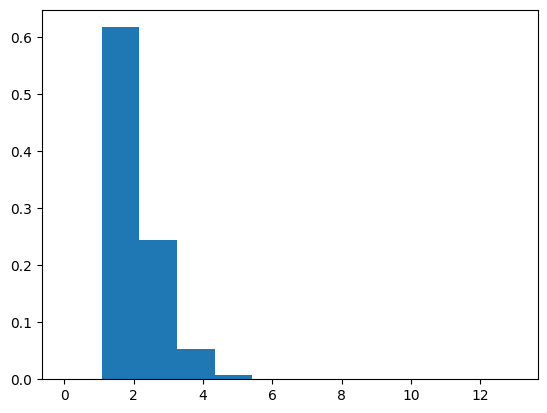

In [ ]:
plt.hist(binpt1[:-1], binpt1, weights=cpt3)